In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from galaxybrain.data_utils import spike_dict
from galaxybrain.plot_utils import spike_dict
from galaxybrain import ramsey 

all_spikes = spike_dict()

Mouse 1
Grabbing Spikes...
Binning Spikes...
[('CP', 176), ('FrMoCtx', 78), ('HPF', 265), ('LS', 122), ('MB', 127), ('SC', 42), ('SomMoCtx', 91), ('TH', 227), ('V1', 334)] Total: 1462
Mouse 2
Grabbing Spikes...
Binning Spikes...
[('FrCtx', 31), ('FrMoCtx', 647), ('HPF', 333), ('LS', 133), ('MB', 40), ('RSP', 112), ('SC', 98), ('SSCtx', 50), ('SomMoCtx', 220), ('TH', 638), ('UNK', 11), ('V1', 251), ('V2', 124)] Total: 2688
Mouse 3
Grabbing Spikes...
Binning Spikes...
[('CP', 134), ('FrMoCtx', 86), ('HPF', 155), ('LH', 4), ('LS', 4), ('RSP', 10), ('SomMoCtx', 10), ('TH', 1878), ('UNK', 15)] Total: 2296


# Data Diagnostic + Supplementary result Figures

## Raw mouse data

## Firing rate over time

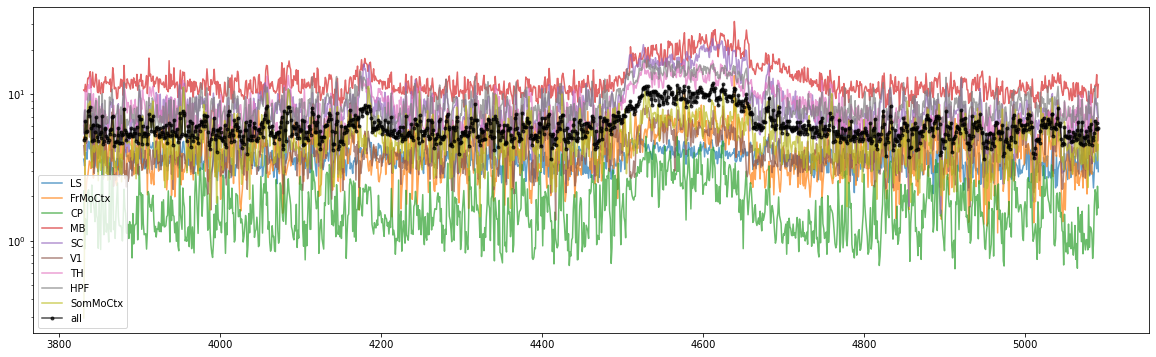

In [2]:
# check over time
i_mouse = 'krebs'
burn_in = 20
# total spikes over time
plt.figure(figsize=(20,6))
for k,v in all_spikes[i_mouse][0][1].items():
    # normalize by number of cells present
    plt.plot(all_spikes[i_mouse][0][0].index[burn_in:-burn_in], all_spikes[i_mouse][0][0][v].sum(1).values[burn_in:-burn_in]/len(v), '-', label=k,alpha=0.7)
plt.plot(all_spikes[i_mouse][0][0].index[burn_in:-burn_in], all_spikes[i_mouse][0][0].sum(1).values[burn_in:-burn_in]/all_spikes[i_mouse][0][0].shape[1], 'k.-', label='all', alpha=0.7)
plt.legend()
plt.yscale('log')

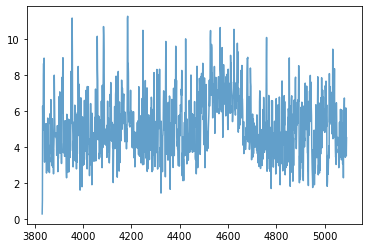

In [3]:
plt.plot(all_spikes[i_mouse][0][0].index[burn_in:-burn_in], all_spikes[i_mouse][0][0][v].sum(1).values[burn_in:-burn_in]/len(v), '-', label=k,alpha=0.7)

## Spike raster

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


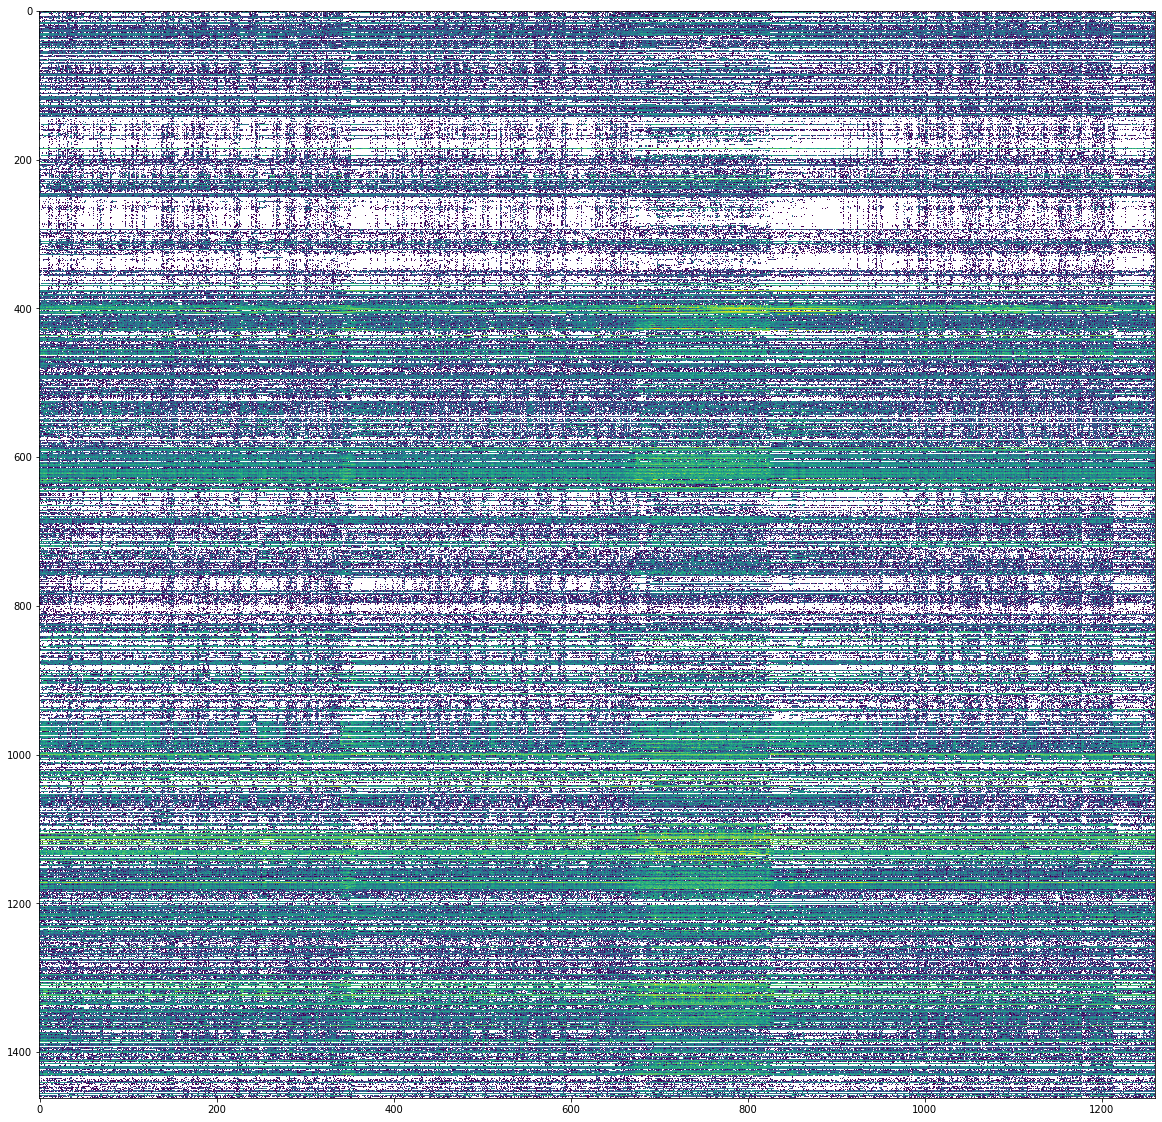

In [31]:
plt.figure(figsize=(20,20))
plt.imshow(np.log10(np.array(all_spikes[i_mouse][0][0]))[burn_in:-burn_in,:].T, aspect='auto')
plt.xlabel('Time'); plt.ylabel('Spikes')

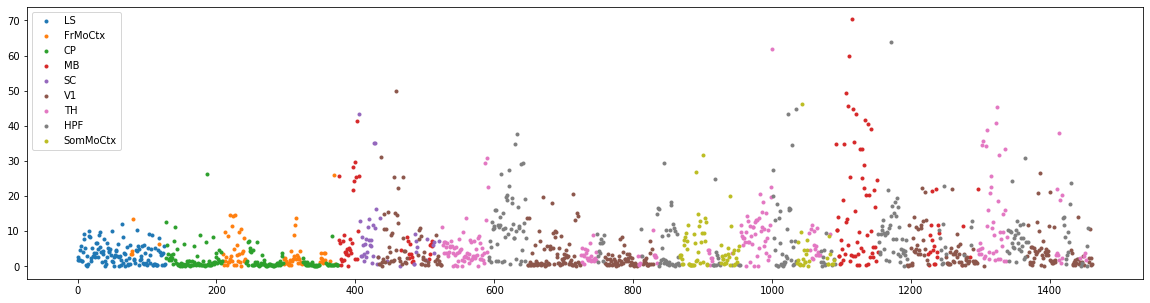

In [32]:
# check over cells
plt.figure(figsize=(20,5))
for k,v in all_spikes[i_mouse][0][1].items():
    plt.plot(v, all_spikes[i_mouse][0][0][v].mean(0), '.', label=k)

plt.legend()

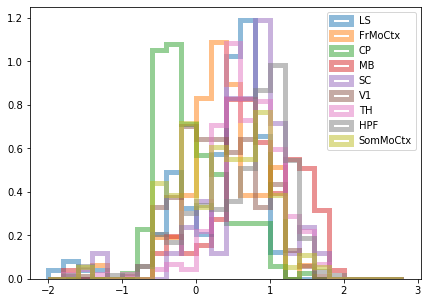

In [33]:
## Distribution of spike count?
plt.figure(figsize=(7,5))
for k,v in all_spikes[i_mouse][0][1].items():
    plt.hist(np.log10(all_spikes[i_mouse][0][0][v].mean(0)), bins=np.arange(-2,3,0.2), label=k, density=True, alpha=0.5, lw=5,histtype='step')
    
plt.legend()

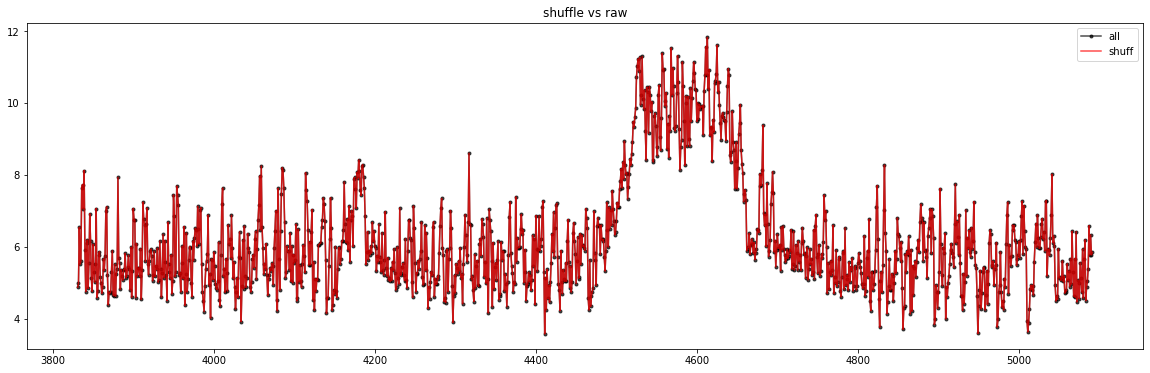

In [30]:
from galaxybrain.analysis_pipe import shuffle_data

plt.figure(figsize=(20,6))
shuffled = shuffle_data(all_spikes[i_mouse][0][0],'space')
plt.plot(all_spikes[i_mouse][0][0].index[burn_in:-burn_in], all_spikes[i_mouse][0][0].sum(1).values[burn_in:-burn_in]/all_spikes[i_mouse][0][0].shape[1], 'k.-', label='all', alpha=0.7)
plt.plot(shuffled.index[burn_in:-burn_in], shuffled.sum(1).values[burn_in:-burn_in]/shuffled.shape[1], 'red', label='shuff', alpha=0.7)
plt.title('shuffle vs raw')
plt.legend()

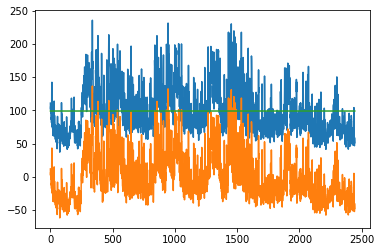

In [261]:
from sklearn.decomposition import PCA
from neurodsp.spectral import compute_spectrum

i_mouse = 1
subset_size = 150
n_pc = int(0.9*subset_size)

data = np.array(all_spikes[i_mouse][0])[burn_in:-burn_in] #shape (2446, 2688)
pca = PCA(n_components=n_pc)
rand_inds = np.sort(np.random.choice(data.shape[1], subset_size, replace=False))
data_subset = data[:,rand_inds]

# DONT TRANSPOSE DATA MATRIX TO HAVE THE CORRECT TIME DIMENSIONS
pca.fit(data_subset)


f_axis, psd = compute_spectrum(data_subset.mean(1), fs=1, nperseg=120, noverlap=60, avg_type='mean')

X_proj = pca.fit_transform(data_subset)

# X transformed (X_proj) is the same as X@pca.components_, (pca.components_ are the eigenvectors)
# plt.plot((data_subset@pca.components_.T)[:,0])
# plt.plot(X_proj[:,0])
# plt.plot((data_subset@pca.components_.T)[:,0]-X_proj[:,0])

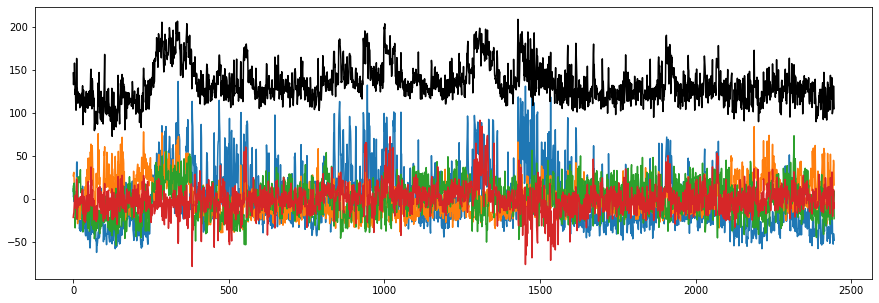

In [270]:
from scipy.stats import zscore
pca.fit(data_subset.T)
pca.components_.shape
plt.figure(figsize=(15,5))
plt.plot(X_proj[:,0:4])
#plt.plot(pca.components_[:1].T, alpha=0.8)
plt.plot(data_subset.mean(1)*20, 'k-')

# Supp Firing rate vs. Exponent vs. Offset

move to sep notebook?

all
CP
HPF
LS
MB
TH
V1


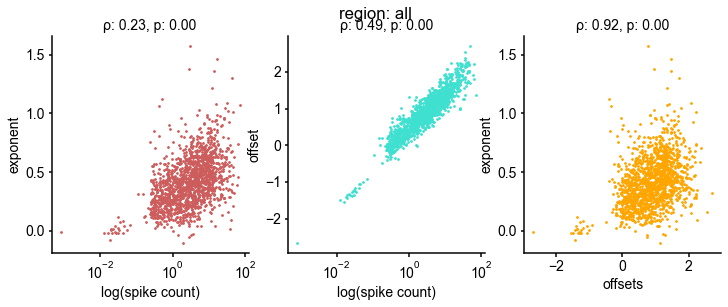

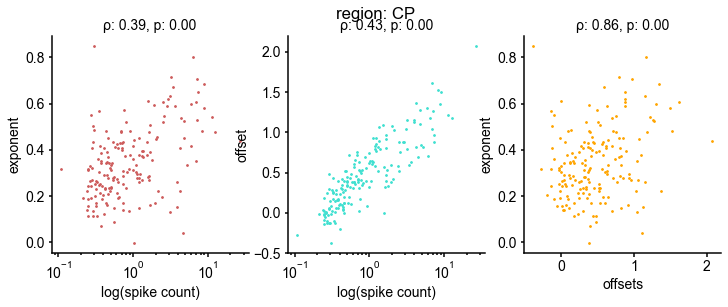

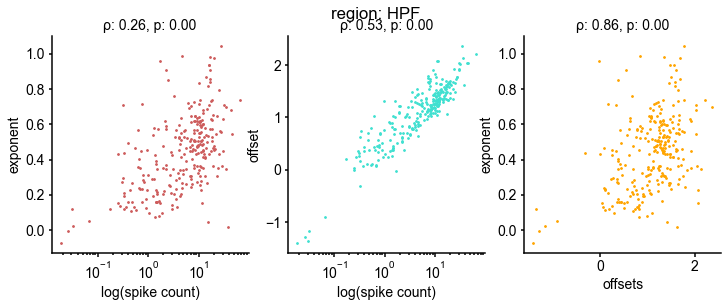

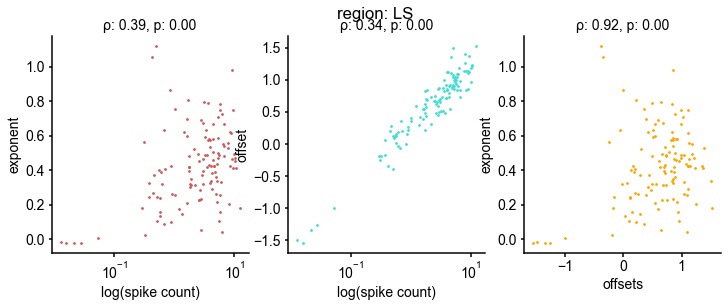

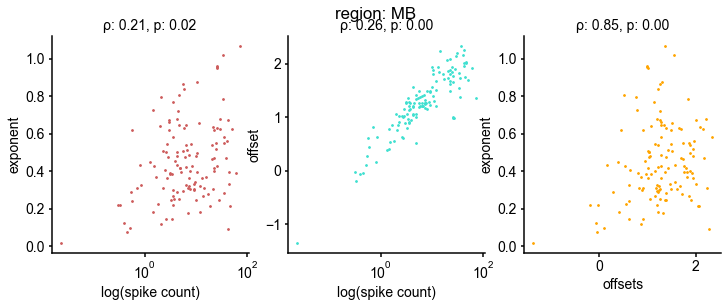

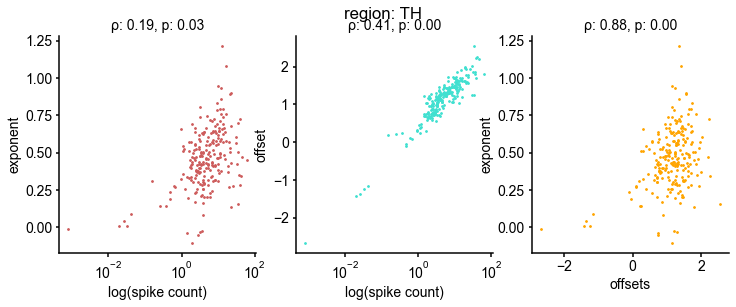

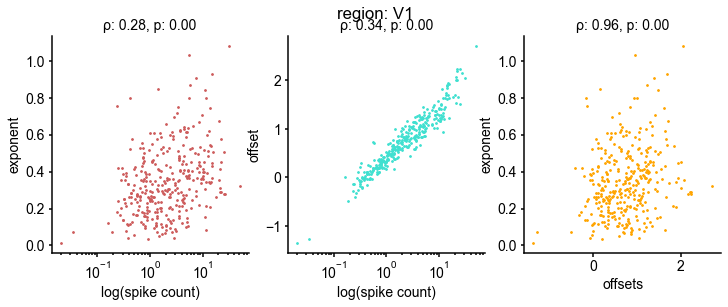

In [139]:
raster_dict = spike_dict([0])
mouse_key = 'krebs'
burn_in = 20 #use for later things 
ft_kwargs = {'fs':1, 'nperseg':120, 'noverlap':60}

from neurodsp.spectral import compute_spectrum

mouse_data = mouse_iter(raster_dict, mouse_key, burn_in)
fg = FOOOFGroup(max_n_peaks=0, aperiodic_mode='fixed', verbose = False)

### CONVERT TO FIRING RATE
for mouse_raster, region_name, region_count in mouse_data:
    total_spikes = mouse_raster.sum(0)
    fr = total_spikes/len(mouse_raster)
    freqs, powers_chans = compute_spectrum(mouse_raster.T, **ft_kwargs)
    fg.fit(freqs, powers_chans) 
    exponents = fg.get_params('aperiodic_params', 'exponent')
    offsets = fg.get_params('aperiodic_params', 'offset')
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.scatter(fr, exponents, color='indianred', s=3);     plt.xscale('log')
    pltlabel(f'ρ: {rho:.2f}, p: {p:.2f}', 'log(spike count)', 'exponent')
    rho, p = stats.spearmanr(total_spikes, exponents)

    plt.subplot(1,3,2)
    plt.scatter(fr, offsets, color='turquoise', s=3);     plt.xscale('log')
    pltlabel(f'ρ: {rho:.2f}, p: {p:.2f}', 'log(spike count)', 'offset')
    rho, p = stats.spearmanr(total_spikes, offsets)
    
    plt.subplot(1,3,3)
    plt.scatter(offsets, exponents, color='orange', s=3);     #plt.xscale('log')
    pltlabel(f'ρ: {rho:.2f}, p: {p:.2f}', 'offsets', 'exponent')
    rho, p = stats.spearmanr(offsets, exponents)
    
    plt.suptitle(f'region: {region_name}')

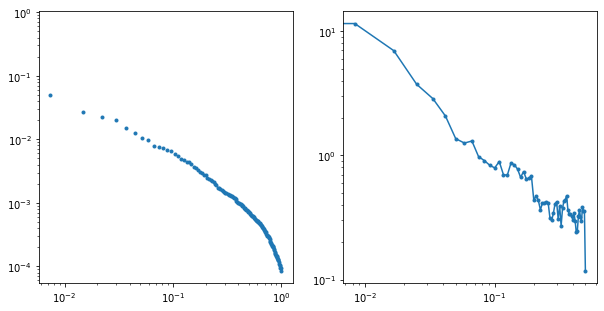

In [220]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(np.arange(n_pc)/n_pc, pca.explained_variance_ratio_, '.')
plt.subplot(1,2,2)
plt.loglog(f_axis, psd, '.-')

notes: 
- when n_pc is close to subset size, the last few eigenvalues become very small
- **crazy**: random.choice() chooses with replacement, which repeats some indices, hence enforcing the eigenvalues to be VERY small (near zero) for high subset size
    - solution: in random.choice(replace=False)
- fit up to 200 eigenvalues maximum or 50th percentile of the e-vales
    - question: is the slow roll-off at higher evals interesting or not?
    - PLOT the eigenspectrum plot where the xaxis is not the rank of PC, but proportion of n_pc (i.e., 0 to 1)
- NEVERMIND[TRANSPOSE DATA MATRIX TO HAVE THE CORRECT TIME DIMENSIONS]

In [14]:
for region_name, region_count in zip(['all', 'V1','HPF','LS'], [1462,334,265,122]):
    mouse_key = 'krebs'
    burn_in = 20
    mouse = all_spikes[mouse_key][0]
    if region_name == 'all':
        mouse_raster = mouse[0].iloc[burn_in:-burn_in]
    else:
        mouse_raster = mouse[0][mouse[1][region_name]].iloc[burn_in:-burn_in] #mouse[1] are indices
    subsetsizes = np.linspace(30,region_count,16, dtype=int)
    ramsey_params = {'n_iters' : 2, 'n_pc' : 0.8, 'f_range' : [0,0.4]}

    eigs, powers, pca_m, space_er, ft_m, time_er,\
    pearson_r, spearman_rho, pearson_p, spearman_p, \
    pca_b, ft_b, pc_range_history = ramsey.ramsey(mouse_raster, subsetsizes, **ramsey_params)
    
    r_i = 2 # random index of subset size
    model = lambda x: (10**offset)*x**-exp
    plt.figure(figsize=(7,7))
    for i in range(2):
        exp = pca_m[:,r_i][i] #.mean(0)
        offset = pca_b[:,r_i][i] #.mean(0)
        _eigs = eigs[r_i]
        x = np.arange(*pc_range_history[r_i]) #np.arange(len(eigs))
        plt.loglog(x, model(x),color='red',alpha=0.8,lw=2)
        plt.loglog(_eigs,color='blue')

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Looking at linear fits

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


<Figure size 504x504 with 0 Axes>

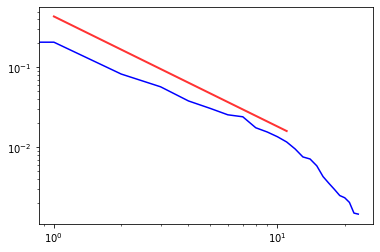

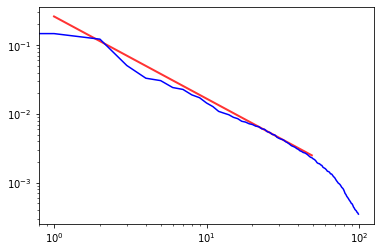

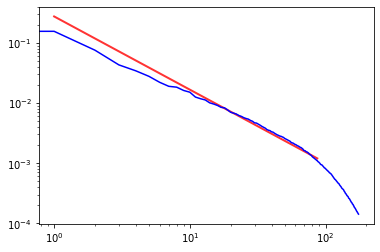

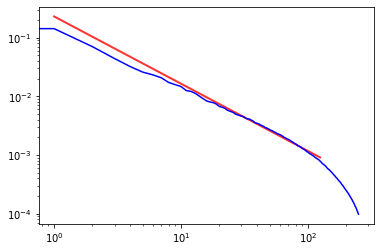

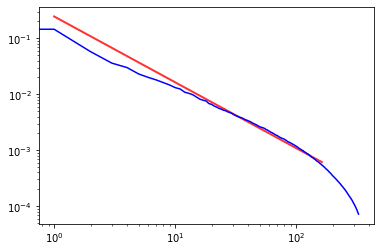

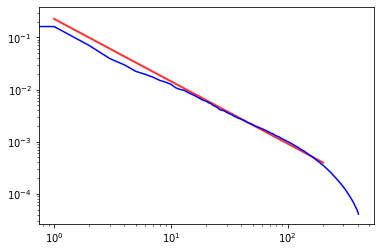

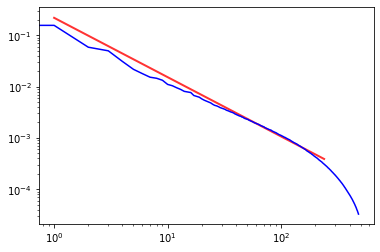

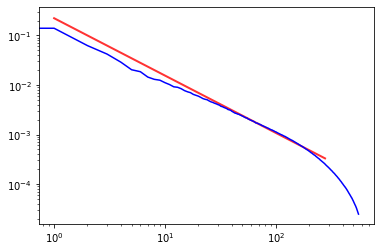

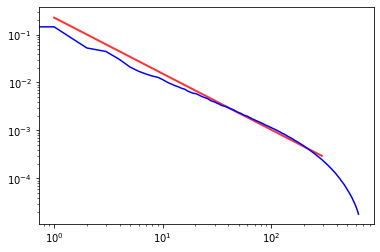

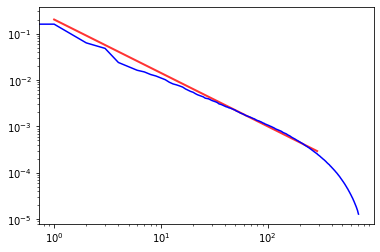

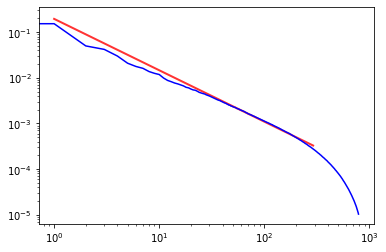

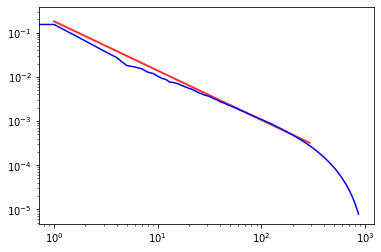

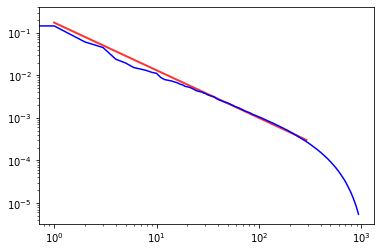

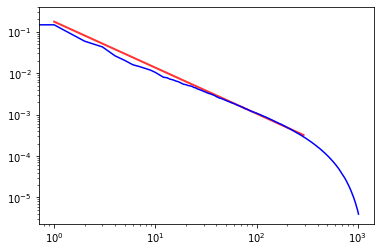

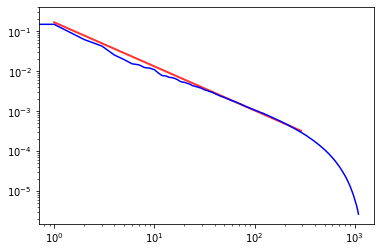

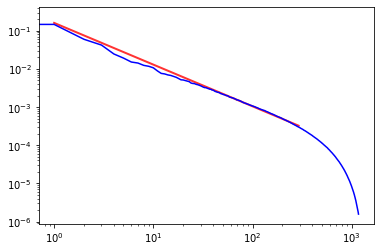

In [23]:
r_i = 2 # random index of subset size
model = lambda x: (10**offset)*x**-exp
plt.figure(figsize=(7,7))
i=0 # iter index
for r_i in range(16):
    plt.figure()
    exp = pca_m[:,r_i][i] #.mean(0)
    offset = pca_b[:,r_i][i] #.mean(0)
    _eigs = eigs[r_i]
    x = np.arange(*pc_range_history[r_i]) #np.arange(len(eigs))
    plt.loglog(x, model(x),color='red',alpha=0.8,lw=2)
    plt.loglog(_eigs,color='blue')

# a look at pc_range

Text(0.5, 1.0, 'curr_pc_range = [0, y]')

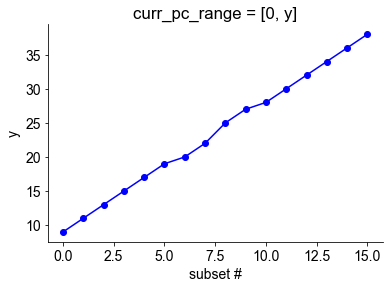

In [120]:
_data=load_results('../data/experiments/expTIMESLOPE',mice=['krebs'], type_='mouse')
data = _data['krebs'][3] # 'all' index
plt.plot(data[2]['curr_pc_range'][:,1], 'o-', color='b'); 
plt.xlabel('subset #');    plt.ylabel('y');      plt.title('curr_pc_range = [0, y]')